#ComputerVision #Pre-TrainedModel 
#TransferLearningModels #VGG-16 #DataAugmentation

#filters #padding #pooling #flattening.

https://towardsdatascience.com/smart-face-lock-system-6c5a77aa5d30

1. Collect the images of the legal owner for which the face recognition model will grant permission..
2. Create an additional folder if we want to add more people who can have access to our system.
3. Resize the images into a (224, 224, 3) shape so that we can pass it through the VGG-16 architecture. 
    
    Note that VGG-16 architecture is pre-trained on the image net weights which have the aforementioned shape.

4. Create variations of the images by performing the image data augmentation on the datasets.
5. Create our custom model on top of the VGG-16 architecture by excluding the top layer.
6. Compilation, training, and fitting the models accordingly with the essential callbacks.
7. Conclude with a final model that can load the weights of the model and perform the face recognition based smart face lock.

In [1]:
#Importing the opencv module for computer vision and capturing images.
import cv2
#Importing os module to access the local system.
import os
#We are going to “on” our default webcam and then proceed to capture the images of our faces which is required for the dataset.
capture = cv2.VideoCapture(0)

directory = "images/folder_train/"
path = os.listdir(directory)

#to label our images from 0 to the total number of photos we click.
count = 0

In [2]:
while True:
    ret, frame = capture.read()
    cv2.imshow('Frame', frame)

    key = cv2.waitKey(1)

    if key%256 == 32:
        img_path = directory + str(count) + ".jpeg"
        cv2.imwrite(img_path, frame)
        count += 1
    
    elif key%256 == 113: 
        break

#After we exit the program we will release the video capture from our webcam and destroy the cv2 graphical window.
capture.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

3. *Resizing the Images:* Reshape our images we collected into a size that is suitable to pass through the VGG-16 architecture which is pre-trained of the imagenet weights.

In [3]:
directory = "folder1_train"
path = os.listdir(directory)

for i in path:
    img_path = directory + i
    image = cv2.imread(img_path)
    #We are rescaling all our images captured from the default frame size to (224, 224) pixels because that is what’s best if we want to try out transfer learning models like VGG-16.
    #We have already captured the images in an RGB format. Thus we already have 3 channels and we do not need to specify that. The required number of channels for a VGG-16 is 3 
    #and the architecture is ideally of shape (224, 224, 3).
    image = cv2.resize(image, (224, 224))
    
    cv2.imwrite(img_path, image)#After the resizing step is completed, we can transfer the Owner’s directory into the images folder.

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'folder1_train'

: 

4. *Image Data Augmentation:* The ImageDataGenerator is used for data augmentation of images.
We will be replicating and making copies of the transformations of the
original images. The Keras Data Generator will use the copies and
not the original ones. This will be useful for training at each epoch.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
#import tensorflow as tf
#from keras.preprocessing.image import ImageDataGenerator
directory = "images"
#parametros que seran usados para el DataAugmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#aplicacion de los parametros de DataAugmentation a las imagenes deseadas
Img_Height=224
Img_width=224
batch_size=128

train_generator = train_datagen.flow_from_directory(directory,
                                                    target_size=(Img_Height, Img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 20 images belonging to 1 classes.


Keras proporciona una interfaz de aplicaciones para cargar y usar modelos previamente entrenados.


Con esta interfaz, **puede crear un modelo VGG utilizando los pesos previamente entrenados proporcionados por el grupo Oxford y usarlo como punto de partida en su propio modelo**, o usarlo como modelo directamente para clasificar imágenes.

Keras provides both the 16-layer and 19-layer version via the VGG16 and VGG19 classes. Let’s focus on the VGG16 model.

## BUILDING THE MODEL

The Face Recognition Model we are building will be trained by using transfer learning. We will be using the VGG-16 model with # no top layer.

In the next code block, we are importing the VGG-16 Model in the variable VGG16_MODEL and making sure we input the model without the top layer.

#Transfer learning

In [3]:
from keras.applications import vgg16

VGG16_MODEL = vgg16.VGG16(input_shape=(Img_width, Img_Height, 3), include_top=False, weights='imagenet')

for layers in VGG16_MODEL.layers: 
    layers.trainable=False

#for layers in VGG16_MODEL.layers:
#    print(layers.trainable)

![SNOWFALL](https://miro.medium.com/max/1400/0*usI_HmpFeF2iPBEM.png)

Al agregar múltiples capas convolucionales y capas de agrupación, la imagen se procesará para la extracción de características. Y habrá capas completamente conectadas que se dirijan a la capa para la función softmax (para un caso de varias clases) o sigmoide (para un caso binario).

Adding multiple convolutional layers and pooling layers, the image will be processed for feature extraction. And there will be fully connected layers heading to the layer for softmax (for a multi-class case) or sigmoid (for a binary case) function

Understanding CNN is understanding how the image data is processed. How to transfer images into data and extract the features for prediction. From this basic structure, there are many modified and converged versions. ResNet, AlexNet, VGG-16 or Inception Networks are some of them. 

The Custom layer consists of the input layer which is, basically the output of the VGG-16 Model.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # dense = tf.keras.layers.Dense

#-----------------------------------------------------------------PROCESSING DATA LAYERS--------------------------------------------------------------------------------------------

#   I   N   P   U   T       M   O   D   E   L       V   G   G   1   6       L   A   Y   E   R

# tengo el modelo entrenado to flama sin la ultima capa. la ultima capa la tengo que personalizar para mis fines.
input_layer = VGG16_MODEL.output


#   C   U   S   T   O   M       L   A   Y   E   R

# Convolutional Layer
# We add a convolutional layer with 32 filters, kernel_size of (3,3), and default strides of (1,1) and we use activation as relu with he_normal as the initializer.
Conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid',
               data_format='channels_last', activation='relu', 
               kernel_initializer=tf.keras.initializers.he_normal(seed=0), 
               name='Conv1')(input_layer)

# MaxPool Layer
# Usaremos la (capa de agrupación/pool layer) para reducir la muestra de las capas de la capa convolucional.
# La agrupación máxima es un tipo de operación que generalmente se agrega a las CNN después de capas convolucionales individuales.
# Cuando se agrega a un modelo, la agrupación máxima reduce la dimensionalidad de las imágenes al reducir la cantidad de píxeles en la salida de la capa convolucional anterior.
# Podría verse como una pérdida de información a primera vista, pero es más bien obtener datos más "significativos" que perderlos.
# Al eliminar algo de ruido en los datos y extraer solo el significativo, podemos reducir el sobreajuste/overfitting y acelerar el cálculo.
Pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid', 
                  data_format='channels_last',name='Pool1')(Conv1)

#-----------------------------------------------------------------FLATTEN LAYER------------------------------------------------------------------------------------------------
# Flatten
# Estamos creando un modelo de clasificación, lo que significa que estos datos procesados ​​deberían ser una buena entrada para el modelo. Debe tener la forma de un vector lineal unidimensional. 
# Las formas rectangulares o cúbicas no pueden ser entradas directas.
# Y está conectado al modelo de clasificación final, que se denomina capa totalmente conectada.
flatten = tf.keras.layers.Flatten(data_format='channels_last',name='Flatten')(Pool1)

#---------------------------------------------------------CLASSIFICATION MODEL  /   FULLY CONNECTED LAYER-----------------------------------------------------------------------
# Fully Connected layer-1
# Las 2 capas completamente conectadas se utilizan con activación como relu, es decir, un Arquitectura densa después de pasar la muestra por una capa aplanadora/flatten layer.
FC1 = tf.keras.layers.Dense(units=30, activation='relu', 
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32), 
            name='FC1')(flatten)

# Fully Connected layer-2
FC2 = Dense(units=30, activation='relu', 
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),
            name='FC2')(FC1)

#-------------------------------------------------------------OUTPUT LAYER-----------------------------------------------------------------------------------
# Output layer
# La capa de salida tiene una activación softmax con num_classes es 2 que predice las probabilidades de num_classes, es decir, el propietario autorizado o un participante adicional o una cara rechazada.
num_classes=2
Out = Dense(units=num_classes, activation='softmax', 
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=3), 
            name='Output')(FC2)

model1 = tf.keras.Model(inputs=VGG16_MODEL.input,outputs=Out)

Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer. In other words, we put all the pixel data in one line and make connections with the final layer.

![SNOWFALL](https://miro.medium.com/max/1400/1*IWUxuBpqn2VuV-7Ubr01ng.png)

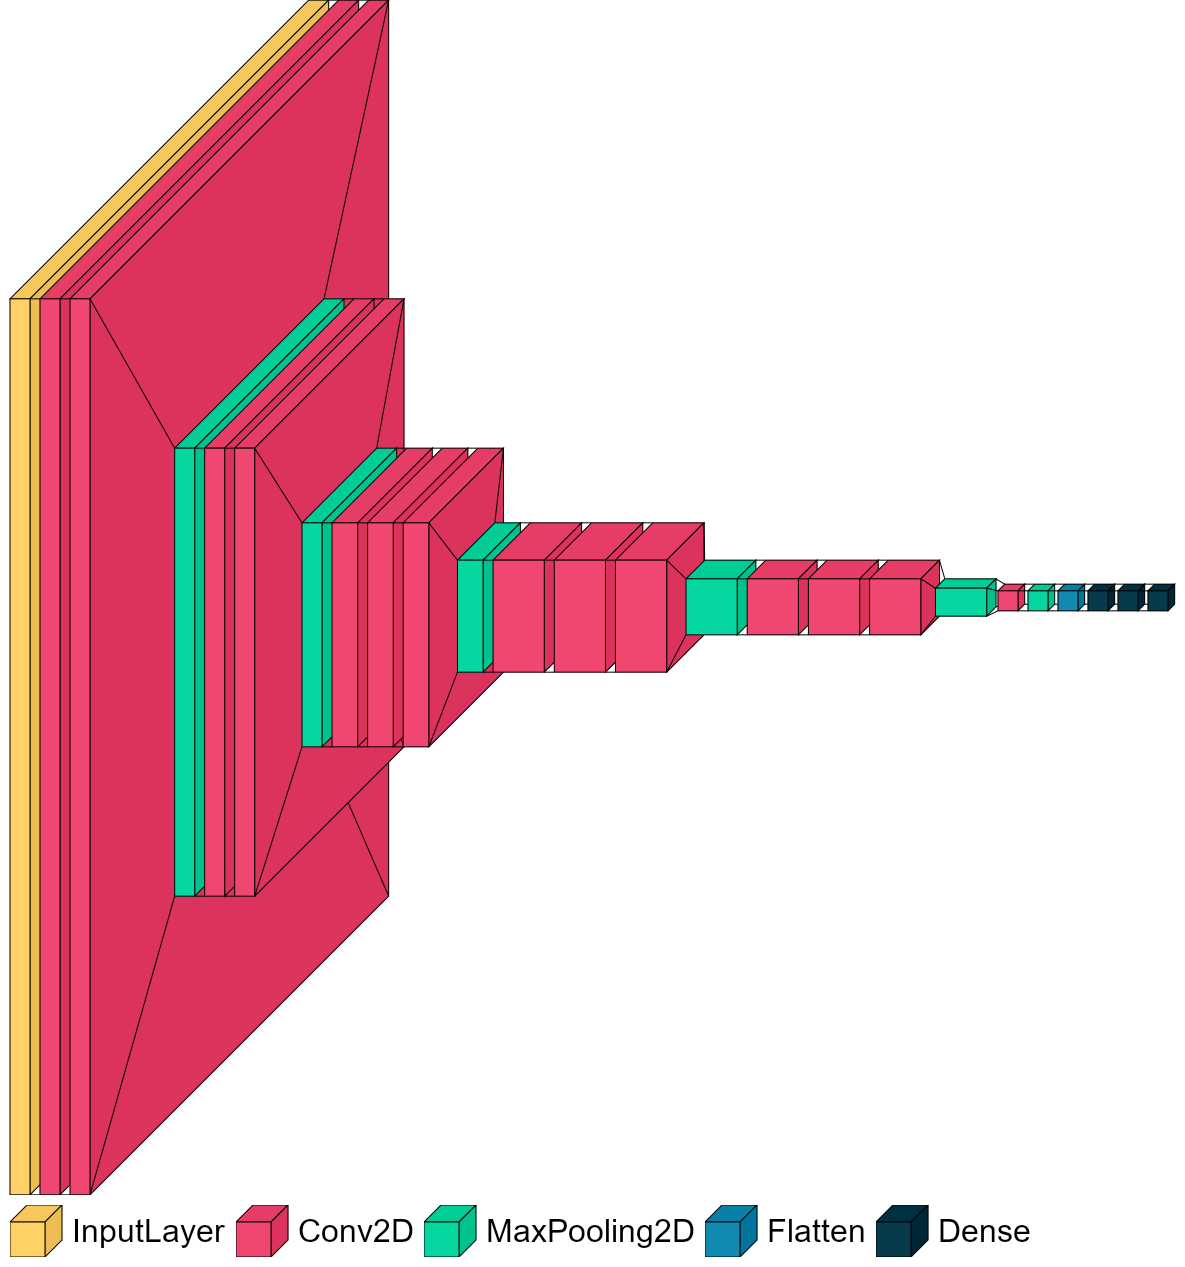

In [8]:
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 32)

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model1, legend=True, font=font)

In [13]:
from ann_visualizer.visualize import ann_viz

ann_viz(model1, view=True, filename='cconstruct_model', title='CNN — Model 1 — Simple Architecture')

ValueError: ANN Visualizer: Layer not supported for visualizing

## CallBacks

We will be importing the 3 required callbacks for training our model.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

# ModelCheckPoint 
# This callback is used for storing the weights of our model after training. 
# We save only the best weights of our model by specifying save_best_only=True. We will monitor our training by using the accuracy metric.
checkpoint = ModelCheckpoint("face_rec.h5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

# ReduceLROnPlateau
# This callback is used for reducing the learning rate of the optimizer after a specified number of epochs. Here, we have specified the patience as 10. 
# If the accuracy does not improve after 10 epochs, then our learning rate is reduced accordingly by a factor of 0.2. The metric used for monitoring here is accuracy as well.
reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=0.00001, verbose = 1)

# Tensorboard
# Is used for plotting the visualization of the graphs, namely the graph plots for accuracy and the loss.
logdir='logsface'
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=True)

## Compile and fit the model

In [ ]:
from tensorflow.keras.optimizers import Adam

model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

c:\Users\mm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import scipy
epochs = 20

model1.fit(train_generator,
           epochs = epochs,
           callbacks = [checkpoint, reduce, tensorboard_Visualization])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 3.0939 - accuracy: 1.0000
Epoch 1: accuracy did not improve from 1.00000
1/1 [==============================] - 8s 8s/step - loss: 3.0939 - accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2.9239 - accuracy: 1.0000
Epoch 2: accuracy did not improve from 1.00000
1/1 [==============================] - 7s 7s/step - loss: 2.9239 - accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 3.0905 - accuracy: 1.0000
Epoch 3: accuracy did not improve from 1.00000
1/1 [==============================] - 6s 6s/step - loss: 3.0905 - accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 2.8400 - accuracy: 1.0000
Epoch 4: accuracy did not improve from 1.00000
1/1 [==============================] - 6s 6s/step - loss: 2.8400 - accuracy: 1.0000 - lr: 1.0000e-05
Epoch 5/20
1/1 [========================

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model1, to_file='model1.png', show_layer_names=True)

NameError: name 'model1' is not defined